deep-graspDetection v0.2.5.1

A source code developed by Shehan Caldera (shehancaldera@gmail.com) for the purpose of training the robot grasp
detection convolutional neural networks (RGD-CNN). The training dataset is acquired from Cornell Grasp Dataset,
and it contains about 885 images and labelled grasps. The complete dataset will be divided into 3 sets:
850 for training and 35 for testing. The training images and grasps have the following format
==> (RG-D images, grasp rectangles with params : x, y, theta, h, w ).

Real-time data augmentation is employed using keras ImagePreprocessing class.

The model has a convolutional base with a similar architecture to that of ResNet-50.


In [1]:
# Define the imports
import keras
import os
import numpy as np
import math
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from PIL import Image
from PIL import ImageOps
import scipy as sp
from skimage.util import crop
import matplotlib.pyplot as plt
import numpy as np
import pypcd
import time
from keras import backend as K
from keras.applications import Xception, VGG16, ResNet50, InceptionResNetV2
from keras import models
from keras import layers
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from shapely.geometry import Polygon
import math


# Global Variables
BASE_DIR = '/media/baxter/DataDisk/Cornell Grasps Dataset/rgd'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
TARGET_IMAGE_WIDTH = 224

/home/baxter/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/baxter/tensorflow/local/lib/python2.7/site-packages/google/protobuf/__init__.py:37: UserWarning: Module tensorflow was already imported from /home/baxter/tensorflow/local/lib/python2.7/site-packages/tensorflow/__init__.pyc, but /home/baxter/tensorflow/lib/python2.7/site-packages/tensorflow-1.8.0-py2.7-linux-x86_64.egg is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)
/home/baxter/tensorflow/local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
# Function for opening images and resizing them appropriately
def open_image(instance_num, image_dir):
    if instance_num < 1000:
        base_filename = 'pcd0'
    else:
        base_filename = 'pcd'

    img_filename = os.path.join(image_dir, base_filename + str(instance_num) + "r" + "." + 'png')
    img = Image.open(img_filename)

    # Cropping image
    crop_img = img.crop(box=(80, 0, 560, 480))

    return crop_img


# Read bboxes
def open_bbox(instance_num, bbox_dir):
    if instance_num < 1000:
        base_filename = 'pcd0'
    else:
        base_filename = 'pcd'

    filename = os.path.join(bbox_dir, base_filename + str(instance_num) + "cpos" + "." + 'txt')
    with open(filename) as f:
        bbox = list(map(
            lambda coordinate: float(coordinate), f.read().strip().split()))

    return bbox[0:8]  # We only consider the first grasp to avoid averaging


# Function for converting bounding boxes to grasps
def bboxes_to_grasps(bbox):
    box = bbox
    # box = open_bbox(instance_num, bbox_dir)
    # box = float(box) / TARGET_IMAGE_WIDTH #Refract the pixel locations in unit distances
    # bbox => grasp (x, y, h, w, sin 2theta, cos 2)
    scale_x = 120
    scale_y = 80

    x = (((box[0] + box[2] + box[4] + box[6]) / 4) - 80) * 0.466666667
    y = ((box[1] + box[3] + box[5] + box[7]) / 4) * 0.466666667
    
    div_n = box[7] - box[1]
    div_d = box[6] - box[0]  # Avoiding the ZeroDivision error in python
    
    if div_d == 0:
        #tan = 0.0
        if div_n > 0:
            tan = 1.79769313e+308
            
        elif div_n < 0:
            tan = -1.79769313e+308
            
    else:
        tan = (box[7] - box[1]) / (box[6] - box[0])

    '''Range of tan is confined between -89 deg : 89 deg as tan(90 deg) reaches infinity
    tan(89 deg) = 57.27 '''
    if tan < 0:
        tan = max(tan, -57.27)
    else:
        tan = min(tan, 57.27)

    theta = np.arctan(tan)
    tan = 10 * tan

    h = np.sqrt(np.power(box[2] - box[0], 2) + np.power(box[3] - box[1], 2)) * 0.466666667
    w = np.sqrt(np.power(box[6] - box[0], 2) + np.power(box[7] - box[1], 2)) * 0.466666667

    grasp = [x, y, theta, h, w]

    return grasp


def grasp_to_bbox(grasp):
    x = grasp[0]
    y = grasp[1]
    theta = grasp[2]
    h = grasp[3]
    w = grasp[4]

    bbox_x = []
    bbox_y = []

    bbox_x.append(x + ((-w / 2) * np.cos(theta)) - ((-h / 2) * np.sin(theta)))
    bbox_y.append(y + ((-h / 2) * np.cos(theta)) + ((-w / 2) * np.sin(theta)))

    bbox_x.append(x + ((-w / 2) * np.cos(theta)) - ((h / 2) * np.sin(theta)))
    bbox_y.append(y + ((h / 2) * np.cos(theta)) + ((-w / 2) * np.sin(theta)))

    bbox_x.append(x + ((w / 2) * np.cos(theta)) - ((h / 2) * np.sin(theta)))
    bbox_y.append(y + ((h / 2) * np.cos(theta)) + ((w / 2) * np.sin(theta)))

    bbox_x.append(x + ((w / 2) * np.cos(theta)) - ((-h / 2) * np.sin(theta)))
    bbox_y.append(y + ((-h / 2) * np.cos(theta)) + ((w / 2) * np.sin(theta)))

    bbox_x.append(x + ((-w / 2) * np.cos(theta)) - ((-h / 2) * np.sin(theta)))
    bbox_y.append(y + ((-h / 2) * np.cos(theta)) + ((-w / 2) * np.sin(theta)))

    bbox_x = np.asarray(bbox_x, dtype='float32')
    bbox_y = np.asarray(bbox_y, dtype='float32')

    return bbox_x, bbox_y


def rmse(y_true, y_pred):

    return K.sqrt(K.mean(K.square(y_pred - y_true)))


# Defining the network architecture
def network_model():
    # Import ResNet50 with imagenet weights
    conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(TARGET_IMAGE_WIDTH, TARGET_IMAGE_WIDTH, 3))

    # Initiate the sequential model
    model = Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(5))  # Last layer does not have an activation as this is a vector regression

    # Freezing the weights of the VGG16 on imagenet weights
    conv_base.trainable = False

    # Verifying the model architecture by inspecting its summary
    model.summary()

    # Compile with Adam optimizer
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=adam, loss='mse', metrics=['acc'])

    return model


In [3]:
print keras.__version__
K.clear_session()

2.1.6


In [4]:
train_data = []
train_targets = []

print(time.strftime("%d.%m.%Y_%H.%M.%S", time.localtime()) + ': Reading the raw CGD data...')
for i in range(100, 950):
    bboxes = open_bbox(i, TRAIN_DIR)

    for bbox_i in range(0, len(bboxes), 8):
        bbox = bboxes[bbox_i:8 + bbox_i]
        
        grasp = bboxes_to_grasps(bbox)
        img = open_image(i, TRAIN_DIR)

        train_targets.append(grasp)

        resized_img = img.resize((TARGET_IMAGE_WIDTH, TARGET_IMAGE_WIDTH))
        img_array = np.asarray(resized_img, dtype='float32')
        train_data.append(img_array)
        print(time.strftime("%d.%m.%Y_%H.%M.%S", time.localtime()) + ': Read data instance: ' + str(i) + 'x' + str(bbox_i / 8))

for i in range(1000, 1035):
    bboxes = open_bbox(i, TEST_DIR)

    for bbox_i in range(0, len(bboxes), 8):
        bbox = bboxes[bbox_i:8 + bbox_i]

        grasp = bboxes_to_grasps(bbox)
        img = open_image(i, TEST_DIR)

        train_targets.append(grasp)

        resized_img = img.resize((TARGET_IMAGE_WIDTH, TARGET_IMAGE_WIDTH))
        img_array = np.asarray(resized_img, dtype='float32')
        train_data.append(img_array)
        print(time.strftime("%d.%m.%Y_%H.%M.%S", time.localtime()) + ': Read data instance: ' + str(i) + 'x' + str(bbox_i / 8))

train_data = np.asarray(train_data, dtype='float32')
train_targets = np.asarray(train_targets, dtype='float32')
        
print(time.strftime("%d.%m.%Y_%H.%M.%S", time.localtime()) + " train_data shape: " + str(train_data.shape))
print(time.strftime("%d.%m.%Y_%H.%M.%S", time.localtime()) + " train_targets shape: " + str(train_targets.shape))

01.08.2018_11.30.02: Reading the raw CGD data...
01.08.2018_11.30.02: Read data instance: 100x0
01.08.2018_11.30.02: Read data instance: 101x0
01.08.2018_11.30.02: Read data instance: 102x0
01.08.2018_11.30.02: Read data instance: 103x0
01.08.2018_11.30.02: Read data instance: 104x0
01.08.2018_11.30.02: Read data instance: 105x0
01.08.2018_11.30.02: Read data instance: 106x0
01.08.2018_11.30.02: Read data instance: 107x0
01.08.2018_11.30.02: Read data instance: 108x0
01.08.2018_11.30.02: Read data instance: 109x0
01.08.2018_11.30.02: Read data instance: 110x0
01.08.2018_11.30.02: Read data instance: 111x0
01.08.2018_11.30.02: Read data instance: 112x0
01.08.2018_11.30.02: Read data instance: 113x0
01.08.2018_11.30.02: Read data instance: 114x0
01.08.2018_11.30.02: Read data instance: 115x0
01.08.2018_11.30.02: Read data instance: 116x0
01.08.2018_11.30.02: Read data instance: 117x0
01.08.2018_11.30.02: Read data instance: 118x0
01.08.2018_11.30.02: Read data instance: 119x0
01.08.2018_

01.08.2018_11.30.04: Read data instance: 280x0
01.08.2018_11.30.04: Read data instance: 281x0
01.08.2018_11.30.04: Read data instance: 282x0
01.08.2018_11.30.04: Read data instance: 283x0
01.08.2018_11.30.04: Read data instance: 284x0
01.08.2018_11.30.04: Read data instance: 285x0
01.08.2018_11.30.04: Read data instance: 286x0
01.08.2018_11.30.04: Read data instance: 287x0
01.08.2018_11.30.04: Read data instance: 288x0
01.08.2018_11.30.04: Read data instance: 289x0
01.08.2018_11.30.04: Read data instance: 290x0
01.08.2018_11.30.04: Read data instance: 291x0
01.08.2018_11.30.04: Read data instance: 292x0
01.08.2018_11.30.04: Read data instance: 293x0
01.08.2018_11.30.04: Read data instance: 294x0
01.08.2018_11.30.04: Read data instance: 295x0
01.08.2018_11.30.04: Read data instance: 296x0
01.08.2018_11.30.04: Read data instance: 297x0
01.08.2018_11.30.04: Read data instance: 298x0
01.08.2018_11.30.04: Read data instance: 299x0
01.08.2018_11.30.04: Read data instance: 300x0
01.08.2018_11

01.08.2018_11.30.06: Read data instance: 458x0
01.08.2018_11.30.06: Read data instance: 459x0
01.08.2018_11.30.06: Read data instance: 460x0
01.08.2018_11.30.06: Read data instance: 461x0
01.08.2018_11.30.06: Read data instance: 462x0
01.08.2018_11.30.06: Read data instance: 463x0
01.08.2018_11.30.06: Read data instance: 464x0
01.08.2018_11.30.06: Read data instance: 465x0
01.08.2018_11.30.06: Read data instance: 466x0
01.08.2018_11.30.06: Read data instance: 467x0
01.08.2018_11.30.06: Read data instance: 468x0
01.08.2018_11.30.06: Read data instance: 469x0
01.08.2018_11.30.06: Read data instance: 470x0
01.08.2018_11.30.06: Read data instance: 471x0
01.08.2018_11.30.06: Read data instance: 472x0
01.08.2018_11.30.06: Read data instance: 473x0
01.08.2018_11.30.06: Read data instance: 474x0
01.08.2018_11.30.06: Read data instance: 475x0
01.08.2018_11.30.06: Read data instance: 476x0
01.08.2018_11.30.06: Read data instance: 477x0
01.08.2018_11.30.06: Read data instance: 478x0
01.08.2018_11

01.08.2018_11.30.08: Read data instance: 637x0
01.08.2018_11.30.08: Read data instance: 638x0
01.08.2018_11.30.08: Read data instance: 639x0
01.08.2018_11.30.08: Read data instance: 640x0
01.08.2018_11.30.08: Read data instance: 641x0
01.08.2018_11.30.08: Read data instance: 642x0
01.08.2018_11.30.08: Read data instance: 643x0
01.08.2018_11.30.08: Read data instance: 644x0
01.08.2018_11.30.08: Read data instance: 645x0
01.08.2018_11.30.08: Read data instance: 646x0
01.08.2018_11.30.08: Read data instance: 647x0
01.08.2018_11.30.08: Read data instance: 648x0
01.08.2018_11.30.08: Read data instance: 649x0
01.08.2018_11.30.08: Read data instance: 650x0
01.08.2018_11.30.08: Read data instance: 651x0
01.08.2018_11.30.08: Read data instance: 652x0
01.08.2018_11.30.08: Read data instance: 653x0
01.08.2018_11.30.08: Read data instance: 654x0
01.08.2018_11.30.08: Read data instance: 655x0
01.08.2018_11.30.08: Read data instance: 656x0
01.08.2018_11.30.08: Read data instance: 657x0
01.08.2018_11

01.08.2018_11.30.10: Read data instance: 815x0
01.08.2018_11.30.10: Read data instance: 816x0
01.08.2018_11.30.10: Read data instance: 817x0
01.08.2018_11.30.10: Read data instance: 818x0
01.08.2018_11.30.10: Read data instance: 819x0
01.08.2018_11.30.10: Read data instance: 820x0
01.08.2018_11.30.10: Read data instance: 821x0
01.08.2018_11.30.10: Read data instance: 822x0
01.08.2018_11.30.10: Read data instance: 823x0
01.08.2018_11.30.10: Read data instance: 824x0
01.08.2018_11.30.10: Read data instance: 825x0
01.08.2018_11.30.10: Read data instance: 826x0
01.08.2018_11.30.10: Read data instance: 827x0
01.08.2018_11.30.10: Read data instance: 828x0
01.08.2018_11.30.10: Read data instance: 829x0
01.08.2018_11.30.10: Read data instance: 830x0
01.08.2018_11.30.10: Read data instance: 831x0
01.08.2018_11.30.10: Read data instance: 832x0
01.08.2018_11.30.10: Read data instance: 833x0
01.08.2018_11.30.10: Read data instance: 834x0
01.08.2018_11.30.10: Read data instance: 835x0
01.08.2018_11

/home/baxter/tensorflow/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


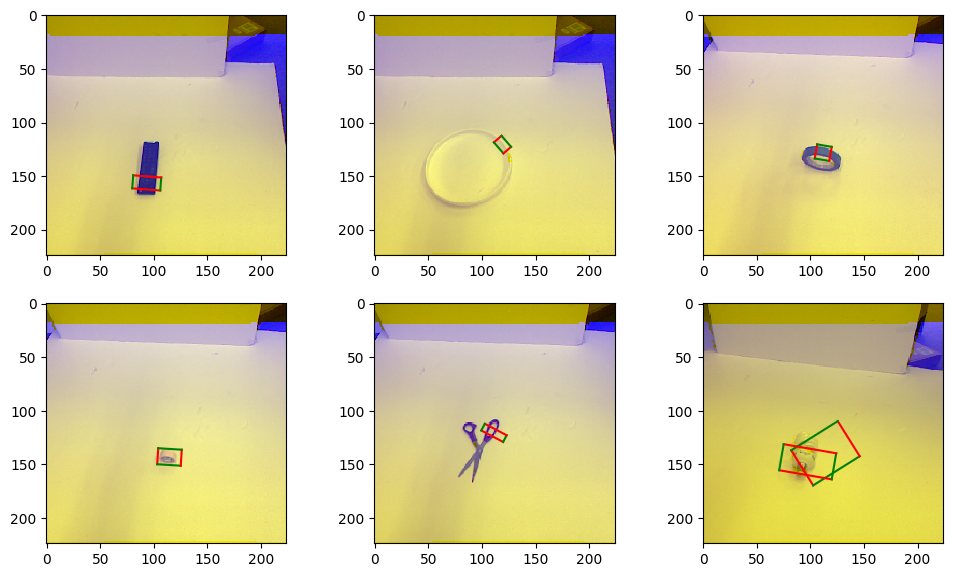

In [5]:
 # Check 6 random samples from the data
fig = plt.figure(figsize=(12, 7), dpi=100, facecolor='w', edgecolor='k')
i_plt = 0
for i_t in range(0, len(train_data), int(len(train_data) / 6)):
    test_img = Image.fromarray(np.uint8(train_data[i_t,]))
    i_plt = i_plt + 1
    if i_plt>6:
        i_plt = 6
    plt.subplot(2,3, i_plt)
    plt.imshow(test_img)
    (bx_pred, by_pred) = grasp_to_bbox(train_targets[i_t,])
    plt.plot(bx_pred[0:2], by_pred[0:2], 'r-', bx_pred[1:3], by_pred[1:3], 'g-', bx_pred[2:4], by_pred[2:4], 'r-', bx_pred[3:5], by_pred[3:5], 'g-')
plt.show()

In [6]:
 # Reading training data into training, validation, and testing subsets

print(time.strftime("%d.%m.%Y_%H.%M.%S", time.localtime()) + ': Creating 3 subsets (train, valid, test) from the CGD data...')

x_train = []
y_train = []
x_valid = []
y_valid = []
x_test = []
y_test = []

x_valid = train_data[0:100]
y_valid = train_targets[0:100]

x_test = train_data[100:150]
y_test = train_targets[100:150]

x_train = train_data[150:len(train_data)]
y_train = train_targets[150:len(train_data)]

x_train = np.asarray(x_train, dtype='float32')
y_train = np.asarray(y_train, dtype='float32')
x_valid = np.asarray(x_valid, dtype='float32')
y_valid = np.asarray(y_valid, dtype='float32')
x_test = np.asarray(x_test, dtype='float32')
y_test = np.asarray(y_test, dtype='float32')

print('Confirm if x_train has NaN:' + str(np.isnan(x_train).any()), 'Confirm if x_train is finite:' + str(np.isfinite(x_train).any()))
if np.isnan(x_train).any() or np.isinf(x_train).any():
    x_train = np.nan_to_num(x_train)

print('Confirm if y_train has NaN:' + str(np.isnan(y_train).any()), 'Confirm if y_train is finite:' + str(np.isfinite(y_train).any()))
if np.isnan(y_train).any() or np.isinf(y_train).any():
    y_train = np.nan_to_num(y_train)

print('Confirm if x_valid has NaN:' + str(np.isnan(x_valid).any()), 'Confirm if x_valid is finite:' + str(np.isfinite(x_valid).any()))
if np.isnan(x_valid).any() or np.isinf(x_valid).any():
    x_valid = np.nan_to_num(x_valid)

print('Confirm if y_valid has NaN:' + str(np.isnan(y_valid).any()), 'Confirm if y_valid is finite:' + str(np.isfinite(y_valid).any()))
if np.isnan(y_valid).any() or np.isinf(y_valid).any():
    y_valid = np.nan_to_num(y_valid)

print('Confirm if x_test has NaN:' + str(np.isnan(x_test).any()), 'Confirm if x_test is finite:' + str(np.isfinite(x_test).any()))
if np.isnan(x_test).any() or np.isinf(x_test).any():
    x_test = np.nan_to_num(x_test)

print('Confirm if y_test has NaN:' + str(np.isnan(y_test).any()), 'Confirm if y_test is finite:' + str(np.isfinite(y_test).any()))
if np.isnan(y_test).any() or np.isinf(y_test).any():
    y_test = np.nan_to_num(y_test)

print(time.strftime("%d.%m.%Y_%H.%M.%S", time.localtime()) + ': Reading the CGD data: DONE')

print('x_train shape: ' + str(x_train.shape), 'y_train shape: ' + str(y_train.shape))
print('x_valid shape: ' + str(x_valid.shape), 'y_valid shape: ' + str(y_valid.shape))
print('x_test shape: ' + str(x_test.shape), 'y_test shape: ' + str(y_test.shape))

01.08.2018_11.30.12: Creating 3 subsets (train, valid, test) from the CGD data...
('Confirm if x_train has NaN:False', 'Confirm if x_train is finite:True')
('Confirm if y_train has NaN:False', 'Confirm if y_train is finite:True')
('Confirm if x_valid has NaN:False', 'Confirm if x_valid is finite:True')
('Confirm if y_valid has NaN:False', 'Confirm if y_valid is finite:True')
('Confirm if x_test has NaN:False', 'Confirm if x_test is finite:True')
('Confirm if y_test has NaN:False', 'Confirm if y_test is finite:True')
01.08.2018_11.30.13: Reading the CGD data: DONE
('x_train shape: (735, 224, 224, 3)', 'y_train shape: (735, 5)')
('x_valid shape: (100, 224, 224, 3)', 'y_valid shape: (100, 5)')
('x_test shape: (50, 224, 224, 3)', 'y_test shape: (50, 5)')


In [7]:
train_datagen = ImageDataGenerator(rotation_range=0.01, width_shift_range=0.2, height_shift_range=0.2)

valid_datagen = ImageDataGenerator()

model = network_model()
epochs = 30
batch_size = 128

# Create callbacks for Tensorboard
callback_list = [keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=5, ),
                 
                 keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
                ]

history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=1000,  # 13 * len(x_train)/batch_size,
                              epochs=epochs,
                              callbacks=callback_list,
                              validation_data=valid_datagen.flow(x_valid, y_valid),
                              verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________
Instructions for updating:
Use the retry module or similar alternatives.
Epoch 1/30
1000/1000 [===========================

In [8]:
model.save('/home/baxter/PycharmProjects/deep-graspDetection/trained_models/grasp_det_v0.2.5.1__01.08.2018.h5')

50/50 [==============================] - 1s 24ms/step
Shape of y_pred: (50, 5)
Shape of y_true: (50, 5)
[ 94.26667   127.85616    -1.2252407  26.281712   12.399642 ]
[ 1.2236373e+02  1.3369780e+02 -1.2322440e-01  1.7784077e+01
  6.5963182e+00]


/home/baxter/tensorflow/local/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


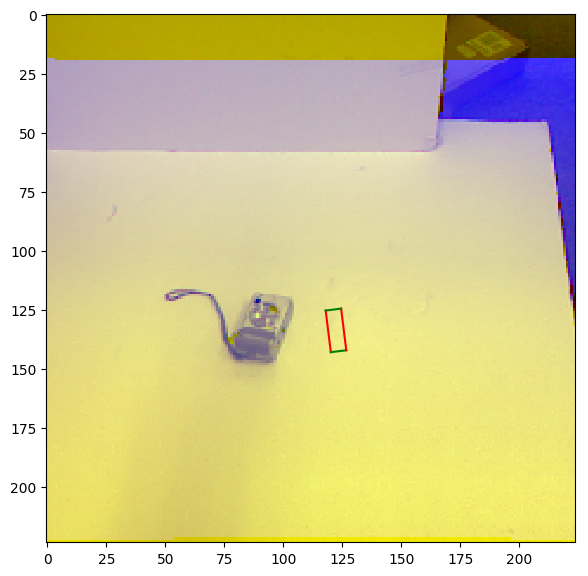

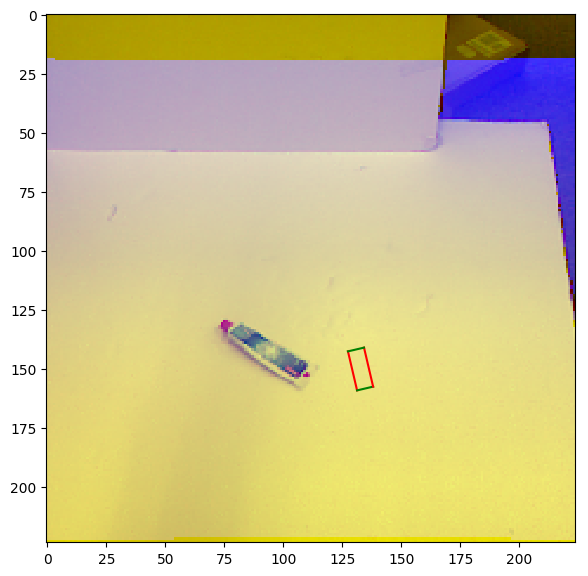

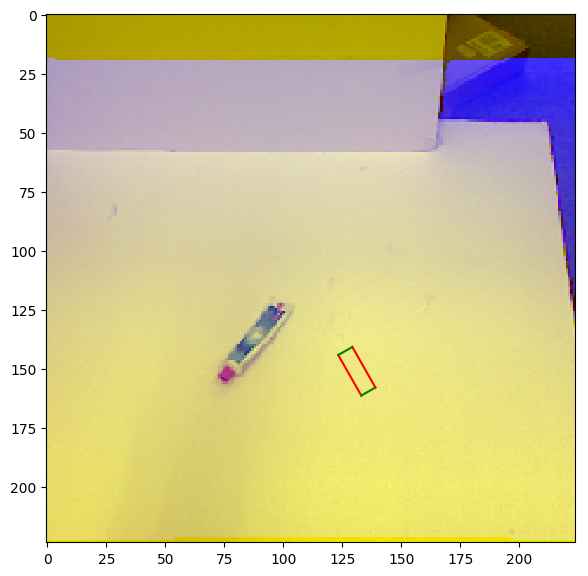

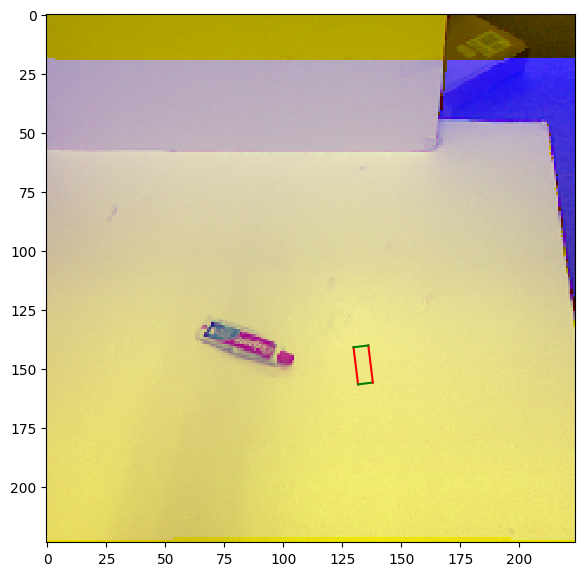

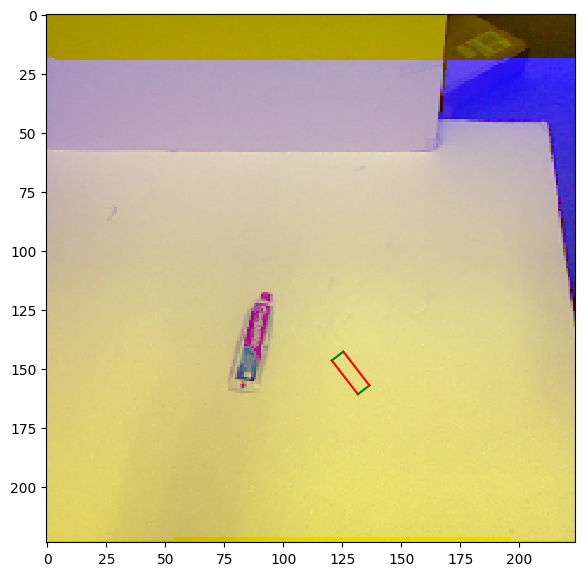

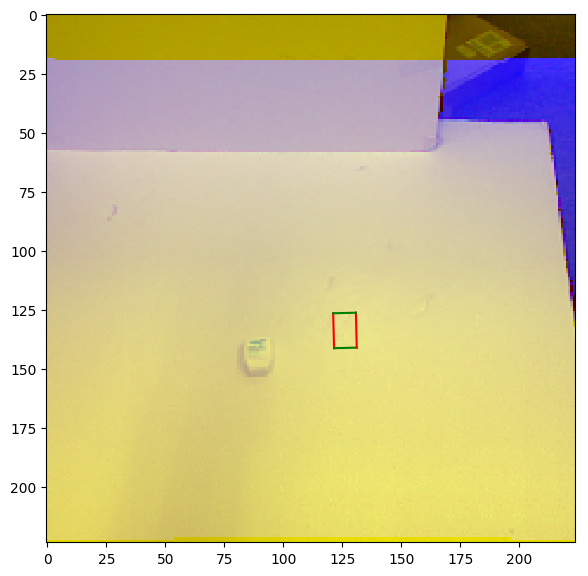

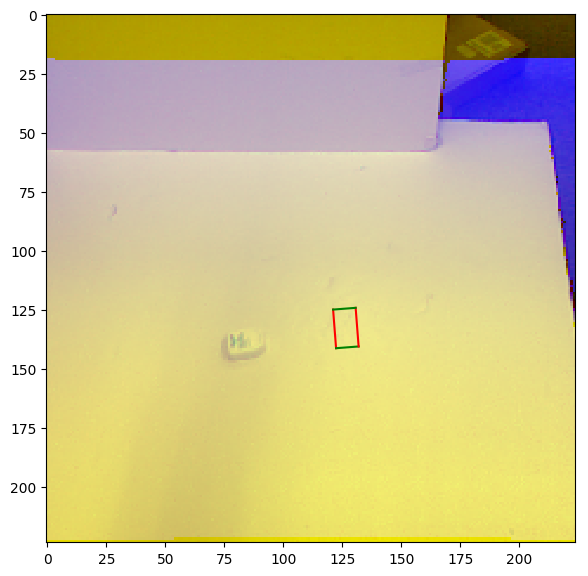

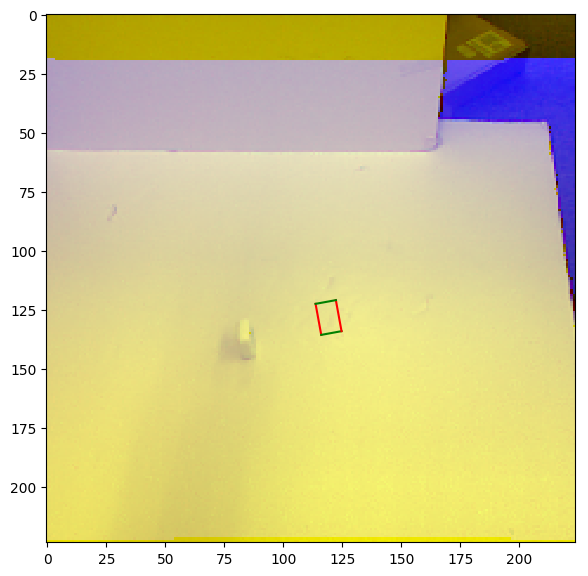

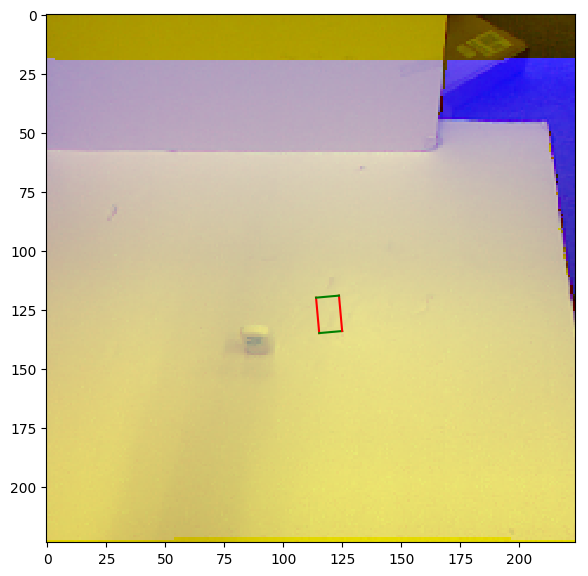

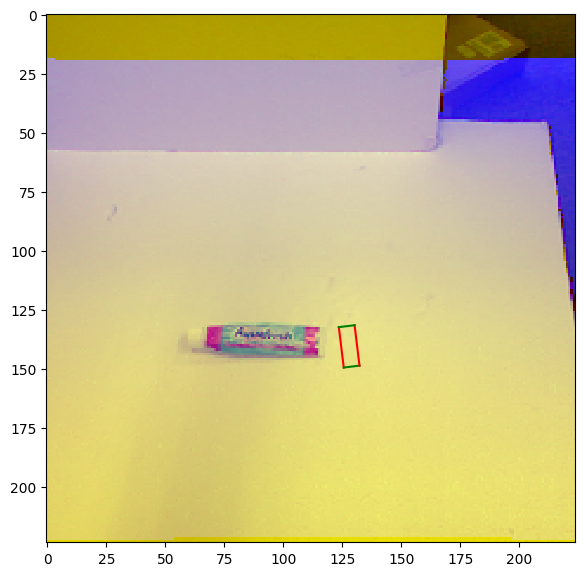

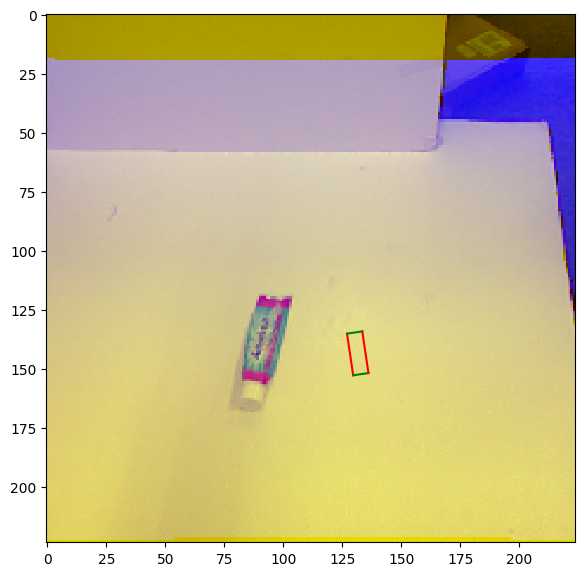

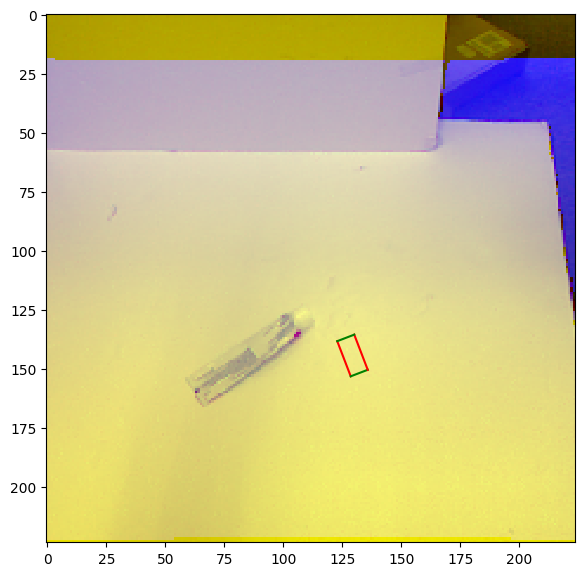

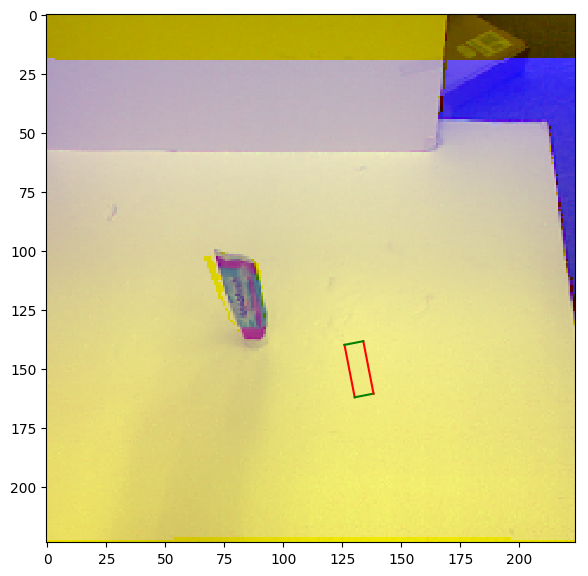

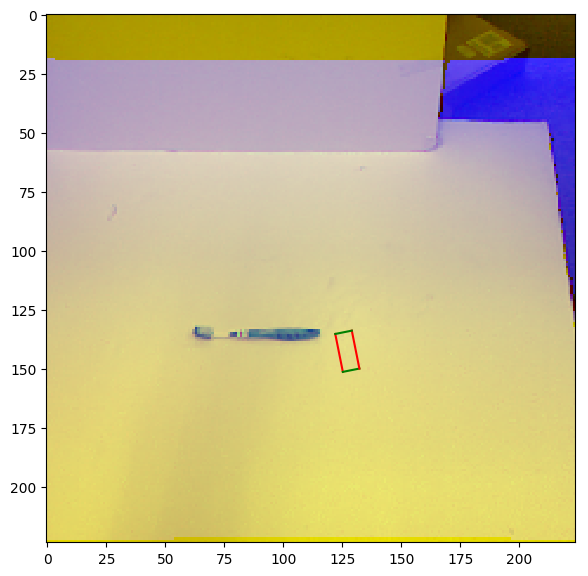

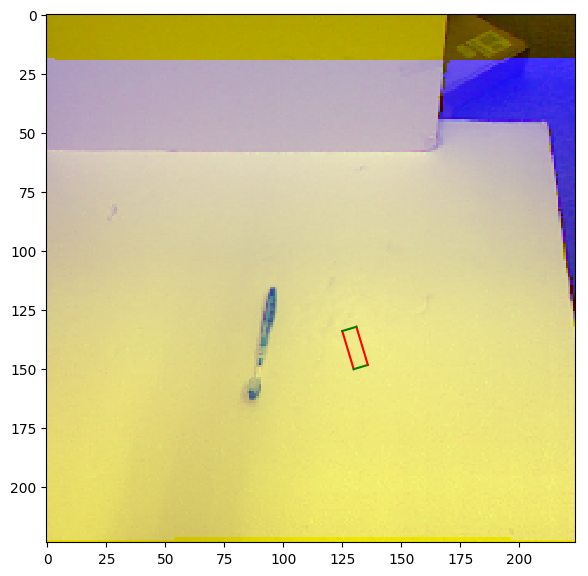

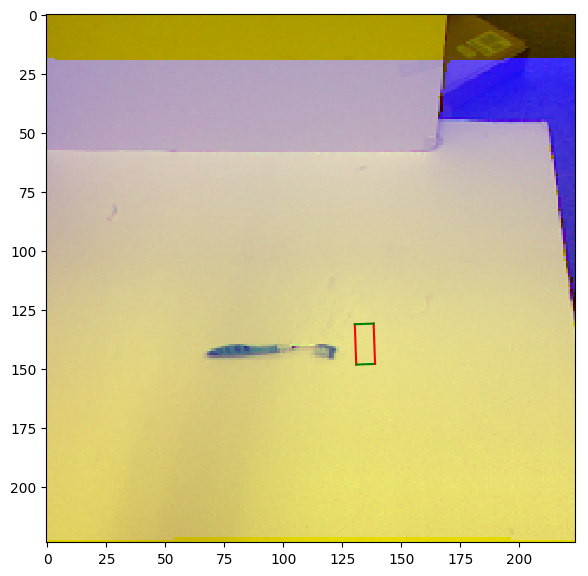

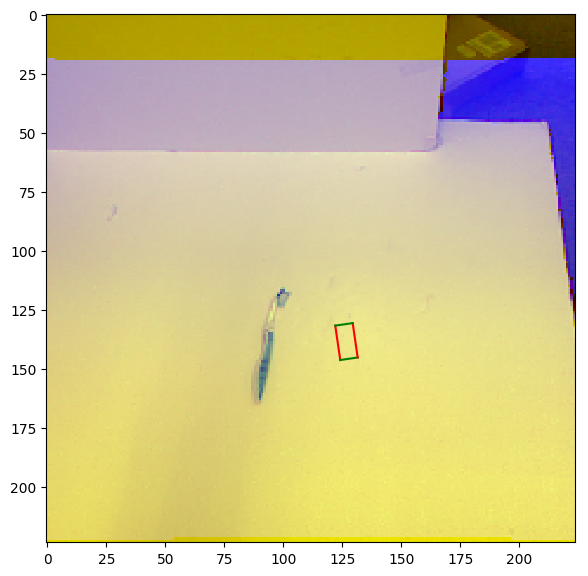

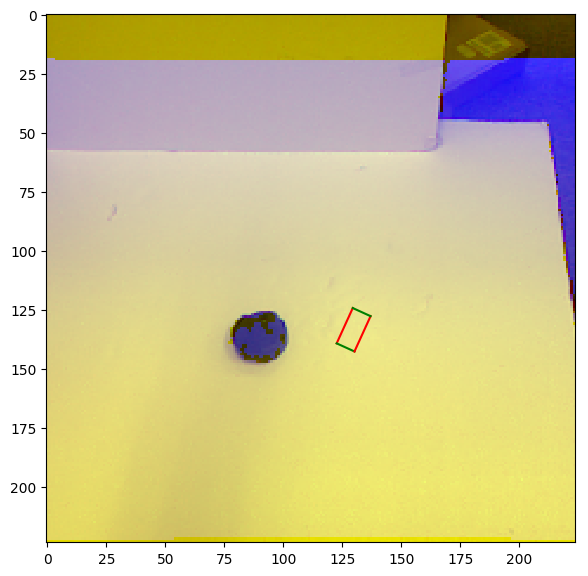

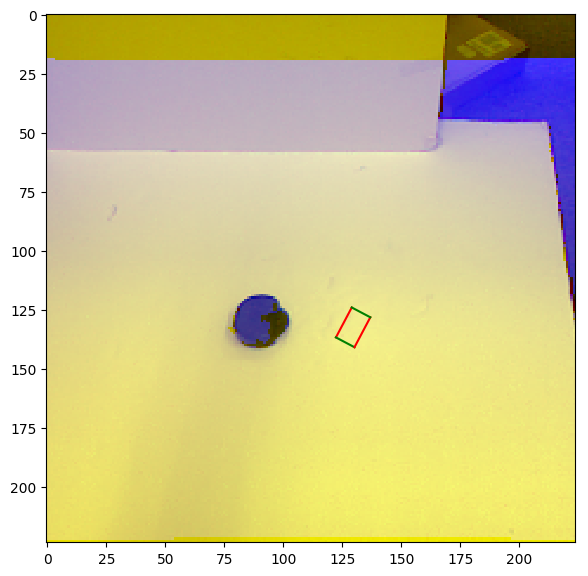

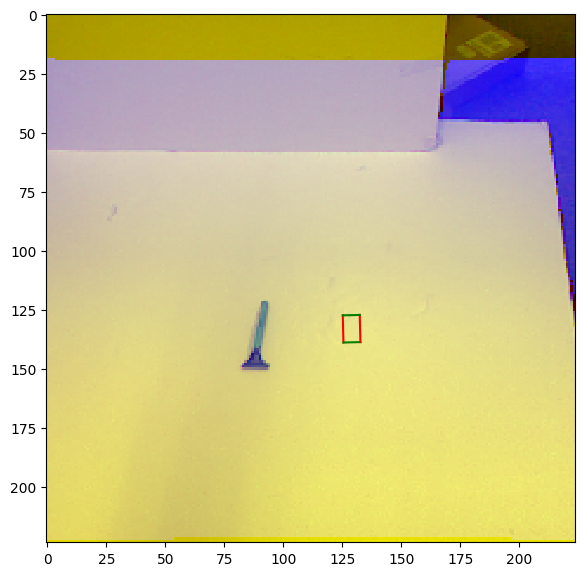

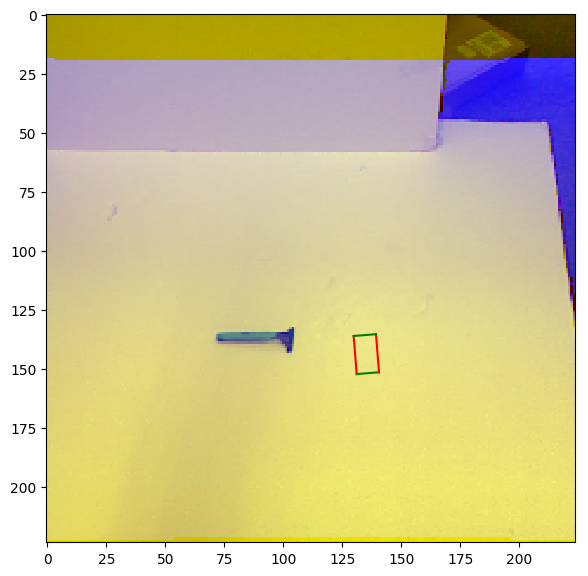

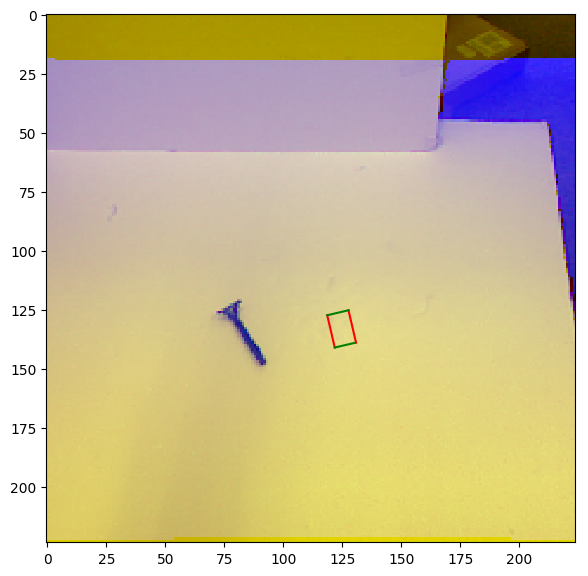

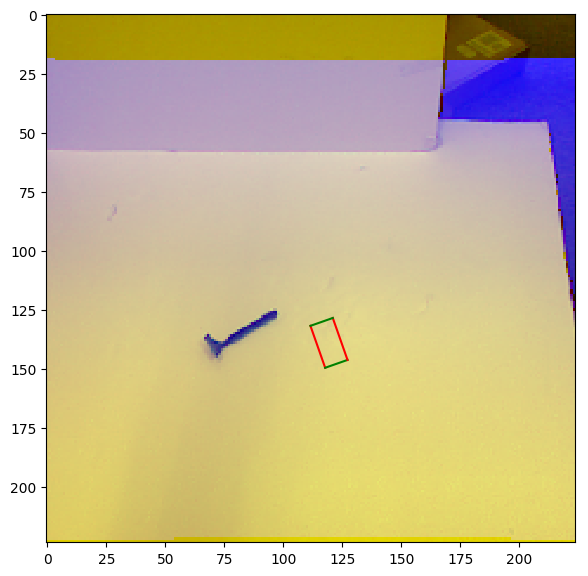

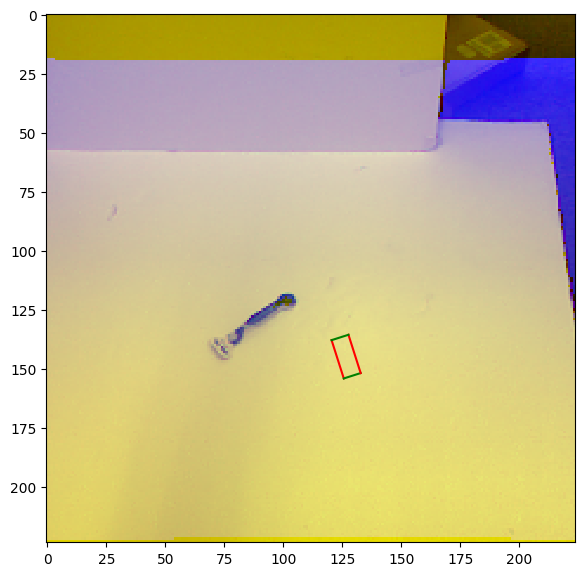

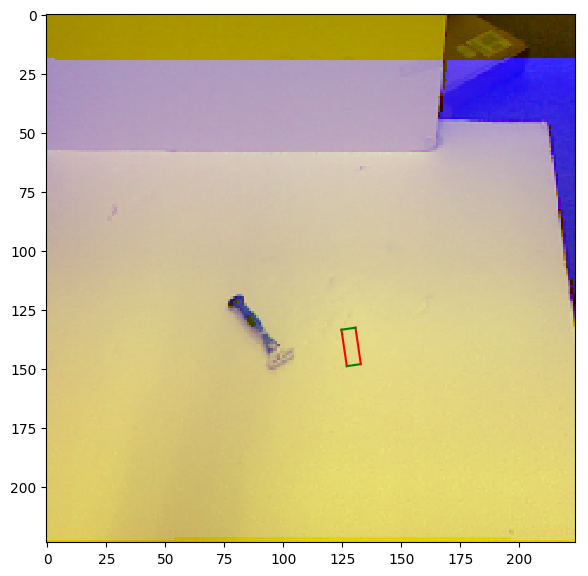

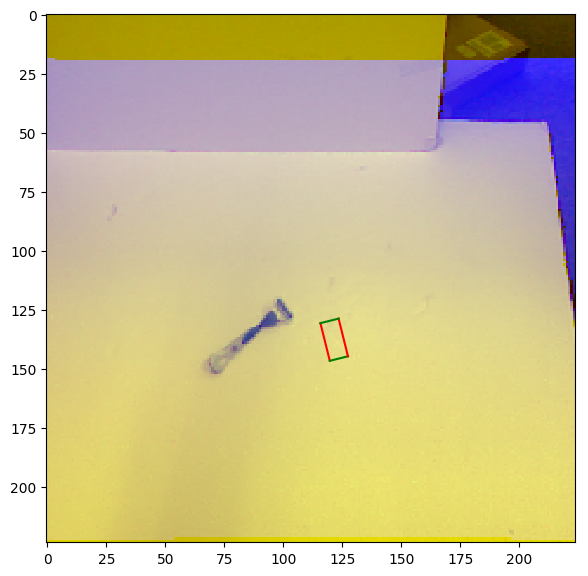

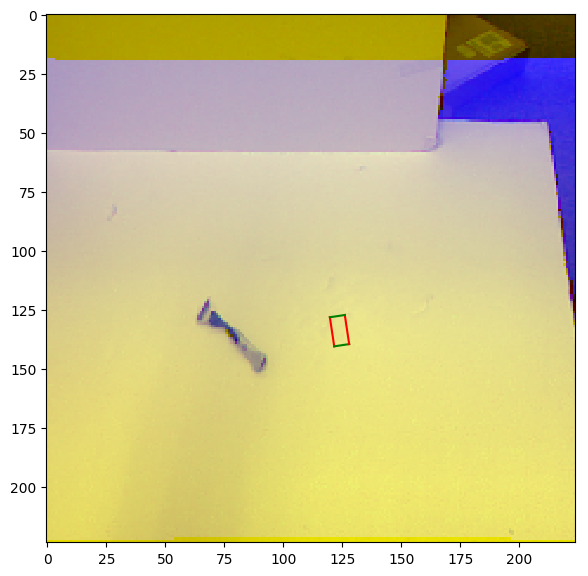

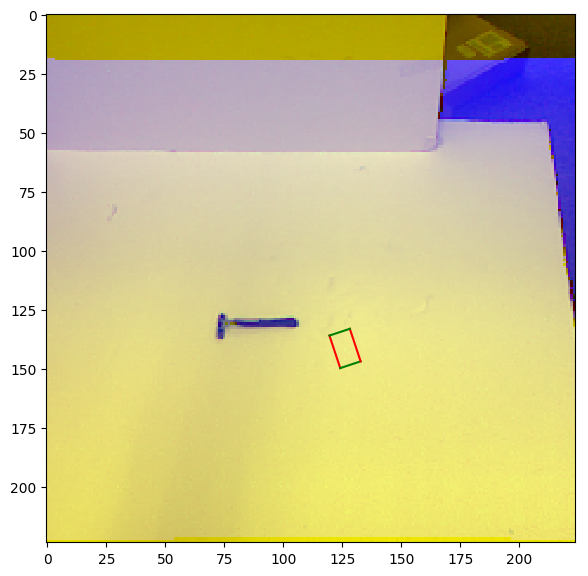

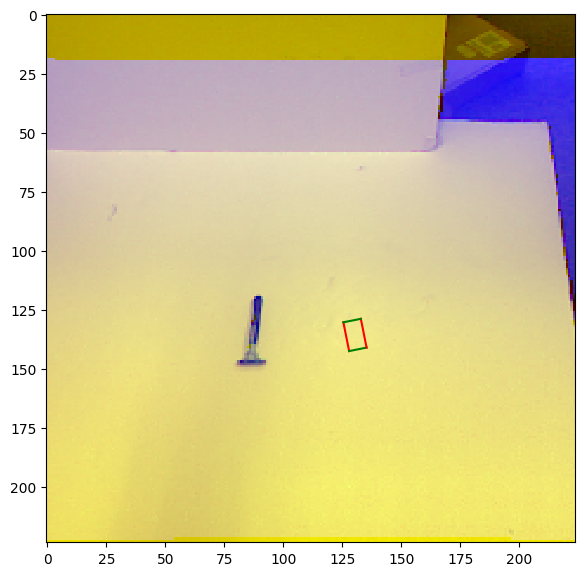

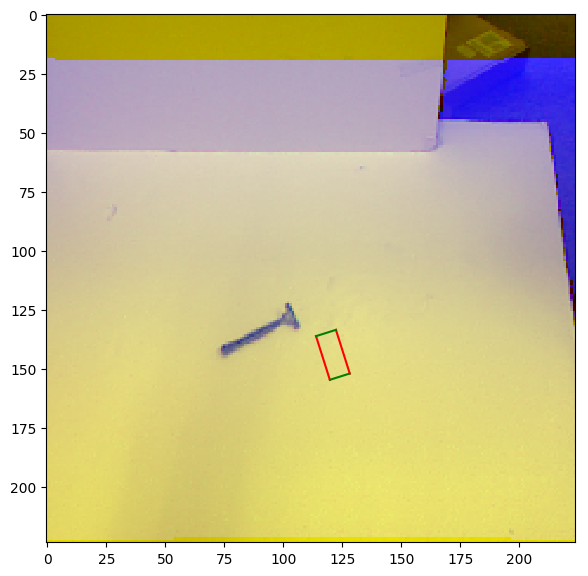

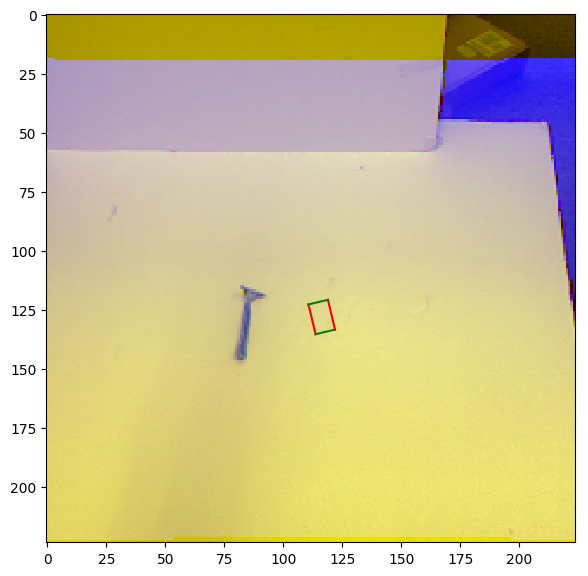

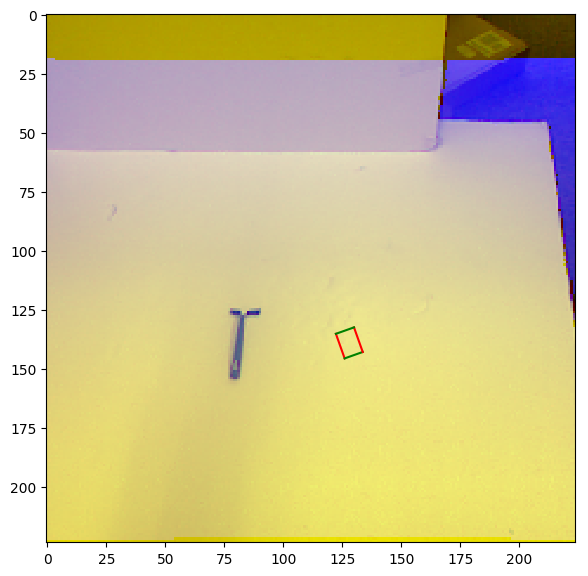

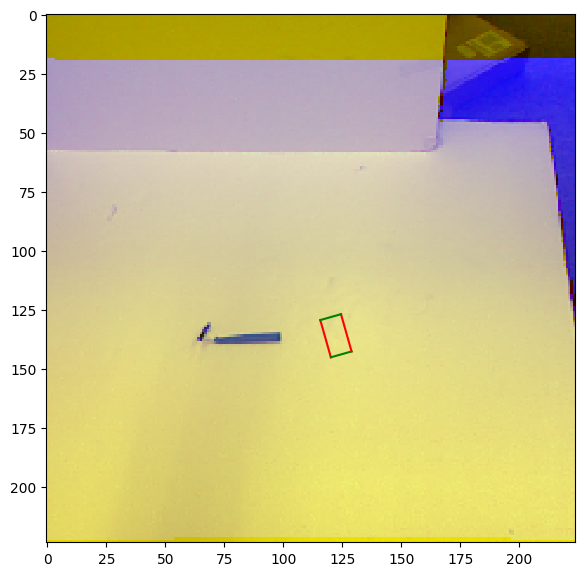

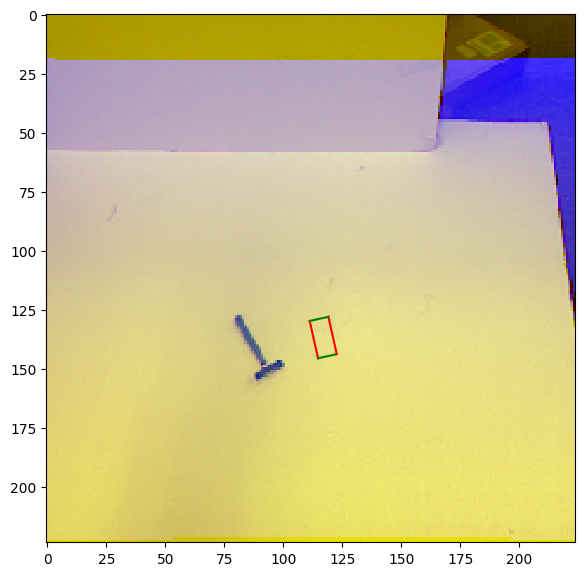

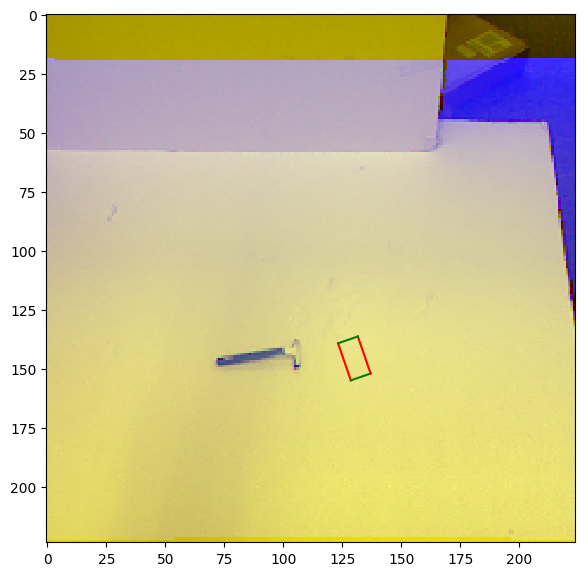

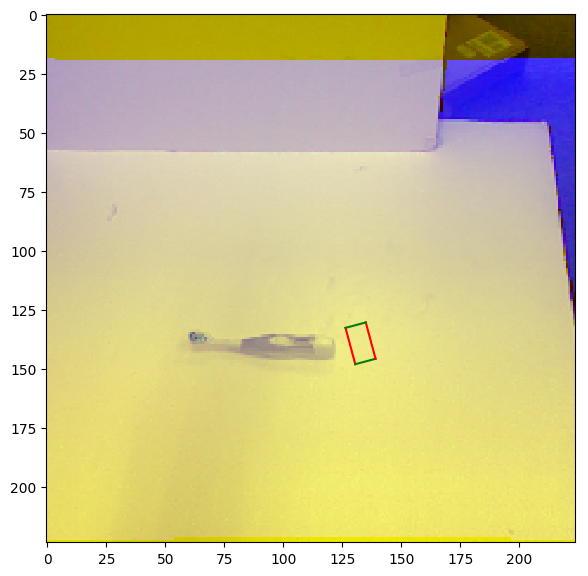

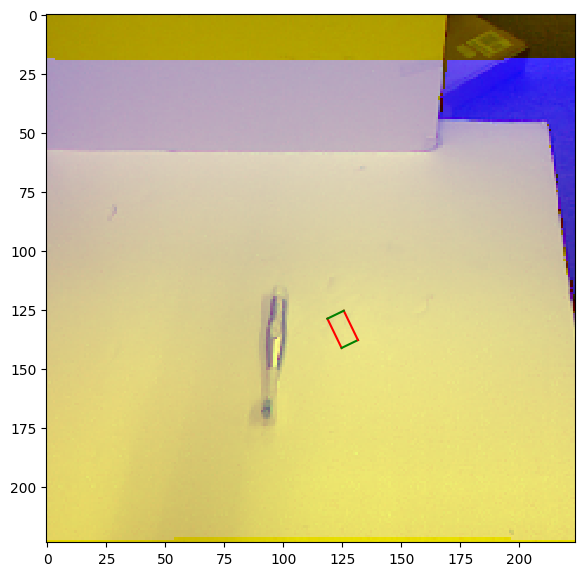

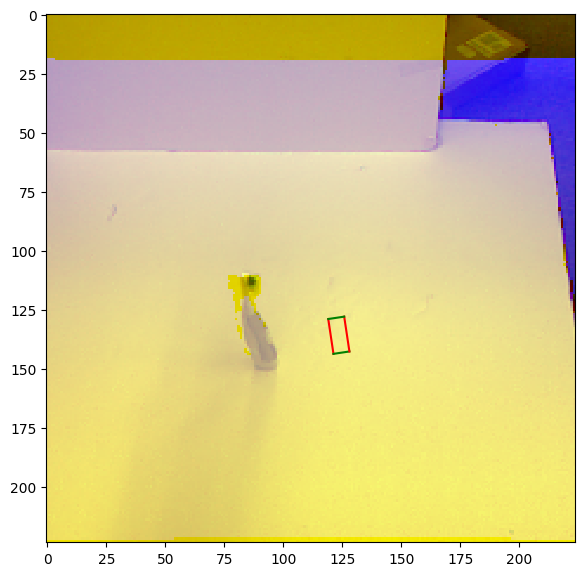

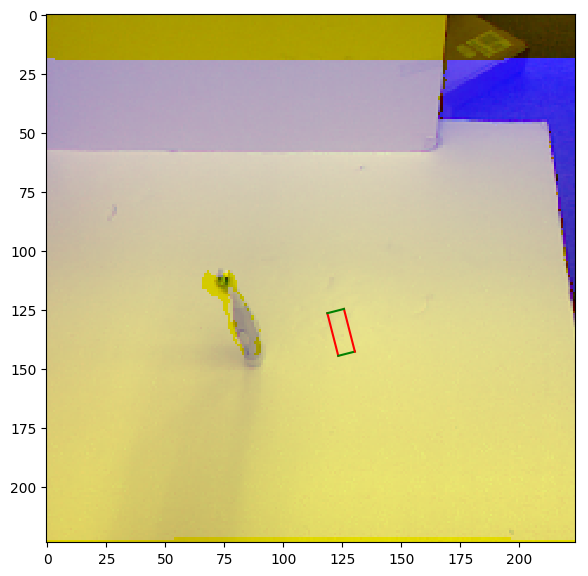

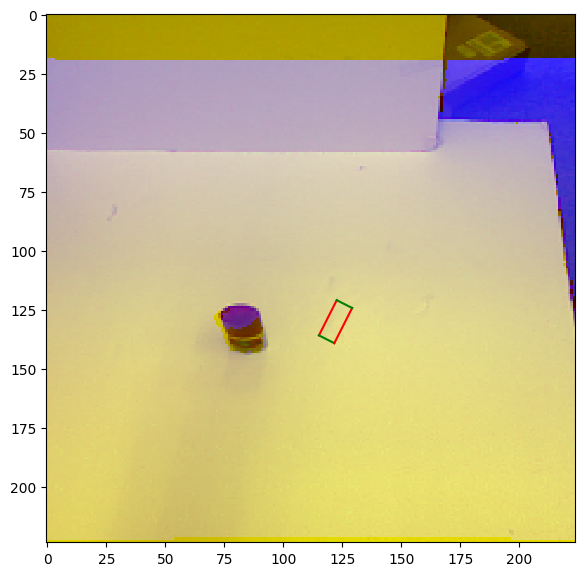

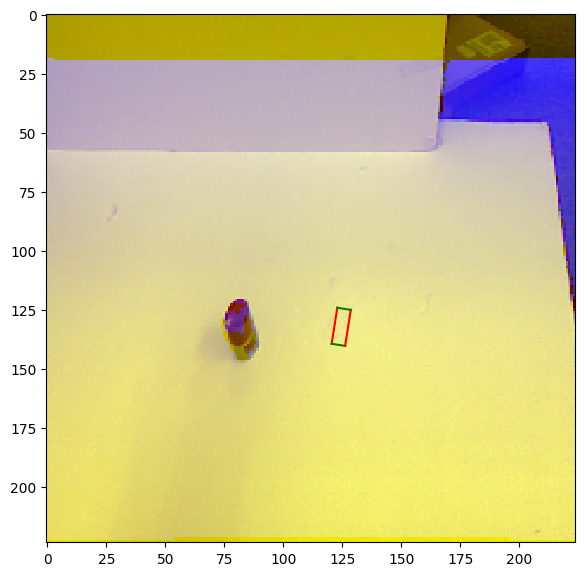

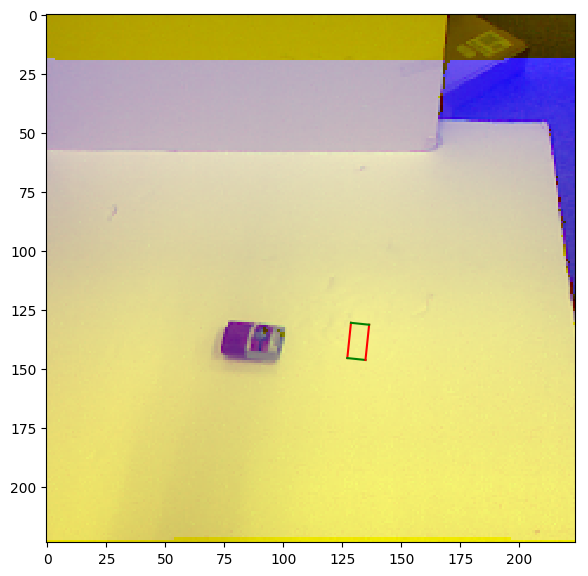

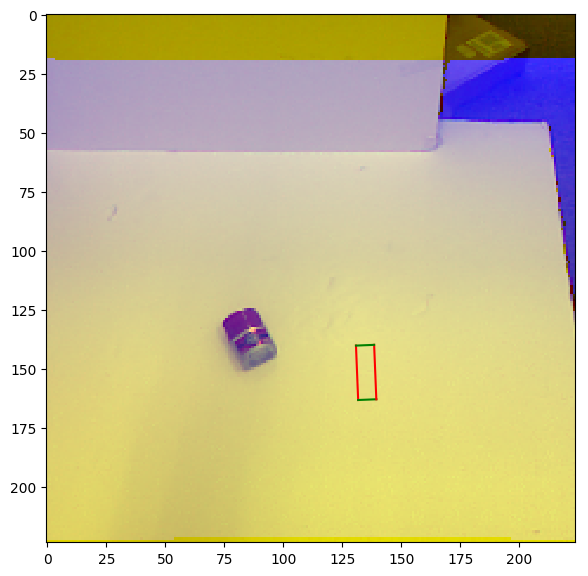

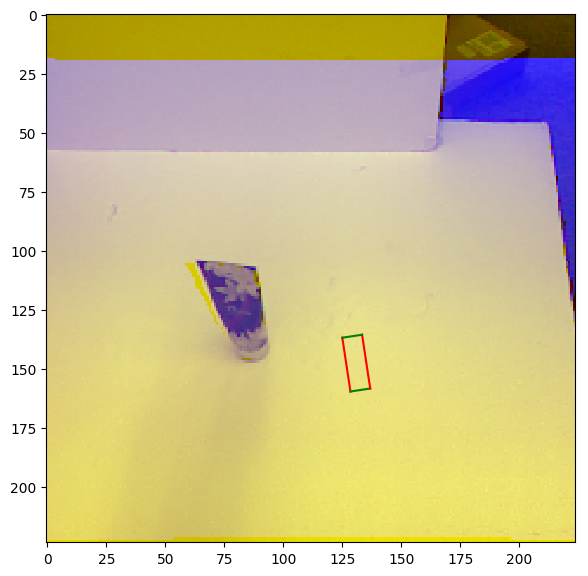

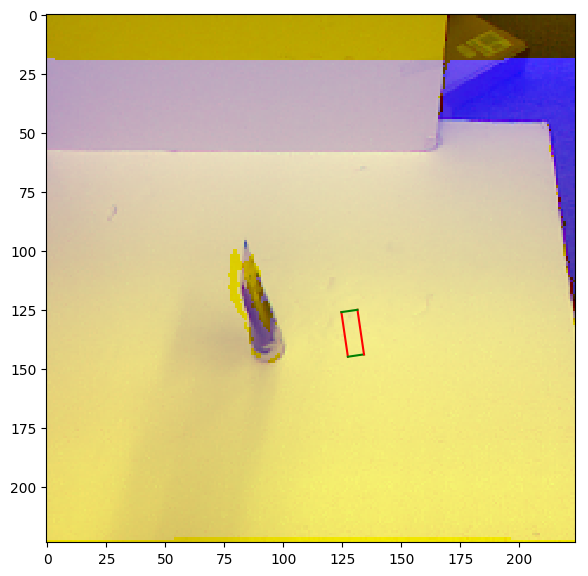

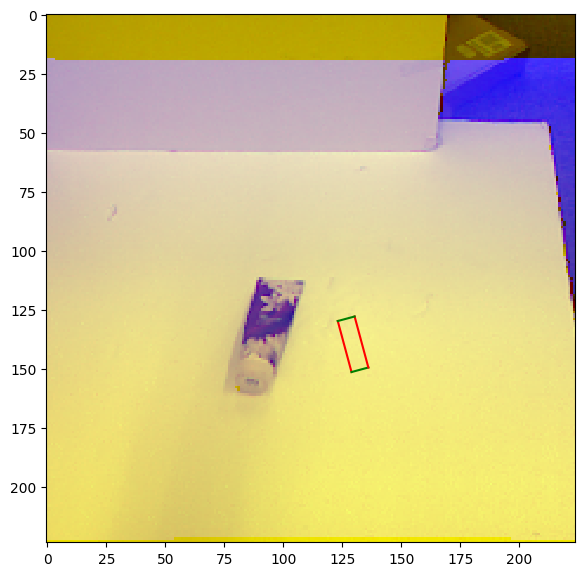

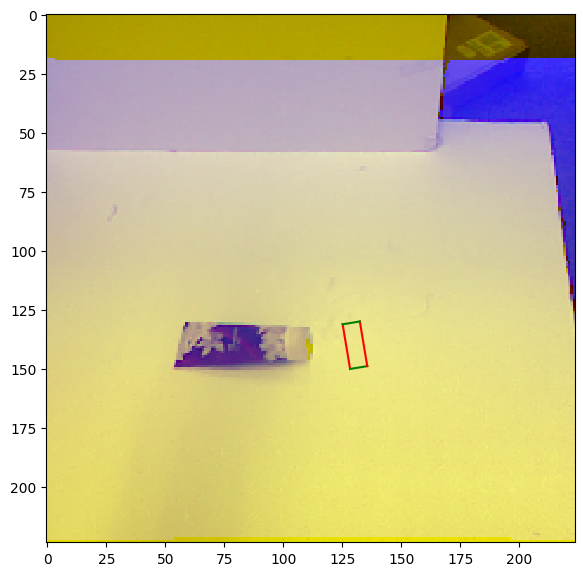

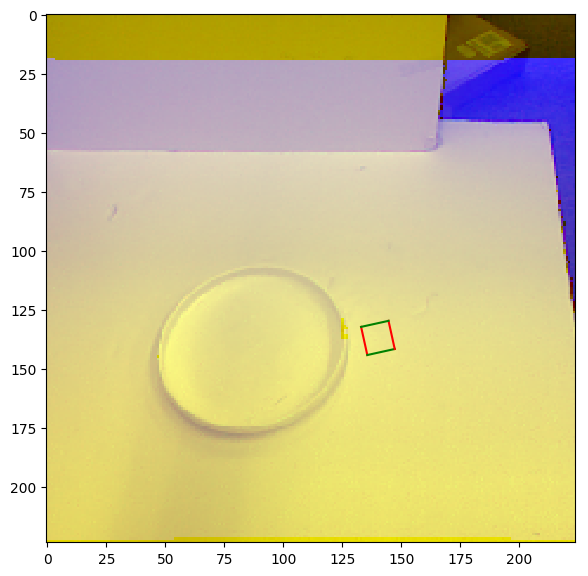

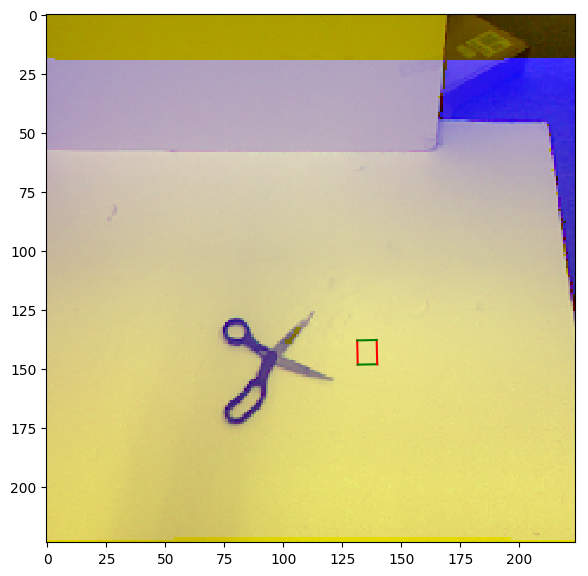

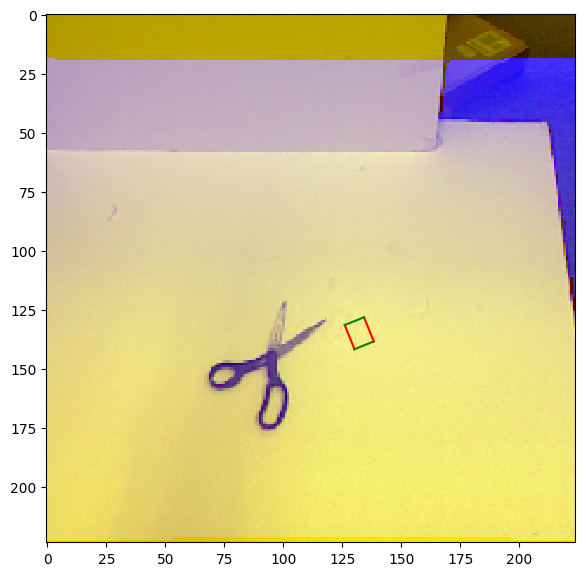

In [9]:
# Test the trained CNN
y_true = y_test
y_pred = model.predict(x_test, batch_size=128, verbose=1)

print("Shape of y_pred: " + str(y_pred.shape))
print("Shape of y_true: " + str(y_true.shape))

grasp_true = np.asarray(y_true, dtype='float32')
grasp_pred = np.asarray(y_pred, dtype='float32')

test_im_array = x_test

print grasp_true[0]
print grasp_pred[0]


for test_i in range(len(test_im_array)):
    fig = plt.figure(figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
    test_img = Image.fromarray(np.asarray(test_im_array[test_i], np.uint8))
    plt.imshow(test_img)
    (bx_pred, by_pred) = grasp_to_bbox(grasp_pred[test_i])
    plt.plot(bx_pred[0:2], by_pred[0:2], 'r-', bx_pred[1:3], by_pred[1:3], 'g-', bx_pred[2:4], by_pred[2:4], 'r-', bx_pred[3:5], by_pred[3:5], 'g-')